In [184]:
import numpy as np
from scipy.interpolate import interp1d # For interpration in matrix
from scipy.optimize import fmin # For optimization
import matplotlib.pyplot as plt

# **Introduction**

In the previous lectures, we mainly focused on solving infinite-horizon dynamic optimization problems. In an infinite horizon, the value function and policy function remain constant over time. Additionally, these functions are the fixed points of the Bellman Operator and Coleman Operator, respectively, allowing us to solve them through iterative methods.

However, **while the economy may be infinite, human life is finite.** In this lecture, we will focus on how an agent with a finite lifespan engages in dynamic optimization. This type of model is useful for analyzing life cycle problems, heterogeneity across generations, and overlapping generation models under more complex settings.

Unlike the infinite-horizon model, **in a finite-horizon model, both the value function and the policy function change over time**. Intuitively, the value function in each period represents the discounted value of the remaining lifetime utility. Since the agent has a finite lifespan, after each period's consumption decision, the discounted value of the remaining lifetime utility decreases. This means that the value function changes in every period, making it impossible to solve for each period's value function using iteration.

However, since the agent must consume all remaining resources by the final period to maximize utility, we are given a new condition: the value function and policy function in the terminal period. Using the Bellman equation, we can work backward from the final period to determine the value functions and corresponding policy functions in earlier periods. This algorithm is known as **Backward Induction**.

We will explain this algorithm using the Robinson Crusoe model, an example taken from Chapter 3 of Yamada et al. (2024).


# **Overview of the Robinson Crusoe Model**

As the name suggests, the Robinson Crusoe model consists of a single consumer with a finite lifespan, who is also the sole producer. He utilizes his initial resource endowment $k_0$ for production. In each period, he allocates resources between investment for future production and consumption. He faces the following sequential problem:

$$
\max_{ \{c_t, k_{t+1}\}_{t=0}^T} \sum_{t=0}^T \beta^t u(c_t) 
$$

subject to:

$$
\begin{aligned}
c_t + k_{t+1} &\leq f(k_t), \\
f(k_t) &\equiv k_t^{\alpha}, \\
u(c_t) &\equiv \ln(c_t), \\
k_0 &\quad \text{given}.
\end{aligned}
$$

This sequential problem can be expressed using the following Bellman equation:

$$
V_t(k_t) = \max_{k_{t+1}} \left\{ \ln(f(k_t) - k_{t+1}) + \beta V_{t+1}(k_{t+1}) \right\}, \quad \text{for} \quad 0 \leq t \leq T.
$$

Here, we do not remove the time subscripts from the Bellman equation because the value function differs in each period and needs to be distinguished.

In the final period $T$, Robinson will invest all his resources in production and consume the entire output. Therefore, the value function in the final period is given by:

$$
V_T(k_T) = \ln(f(k_T)).
$$

The final period's value function can also be expressed as a special case of the Bellman equation with $k_{T+1} = 0$ and $V_{T+1}(k_{T+1}) = 0$:

$$
\begin{aligned}
V_T(k_T) &= \max_{k_{T+1}=0} \left\{ \ln(f(k_T) - k_{T+1}) + \beta V_{T+1}(k_{T+1}) \right\} \\
         &= \ln(f(k_T)).
\end{aligned}
$$

Using the Bellman equation, we can recursively determine the value functions for periods $\{T-1, T-2, \dots, 0 \}$ as follows:

$$
V_{T-1}(k_{T-1}) = \max_{k_T} \left\{ \ln(f(k_{T-1}) - k_T) + \beta V_T(k_T) \right\},
$$

$$
V_{T-2}(k_{T-2}) = \max_{k_{T-1}} \left\{ \ln(f(k_{T-2}) - k_{T-1}) + \beta V_{T-1}(k_{T-1}) \right\},
$$

$$
\vdots
$$

$$
V_0(k_0) = \max_{k_1} \left\{ \ln(f(k_0) - k_1) + \beta V_1(k_1) \right\}.
$$

Thus, through **Backward Induction**, we can deduce all the value functions from period $T$ backward, thereby obtaining the optimal policy function $k_{t+1}(k_t)$.


# **Backward Induction**

## **Algorithm**

**1. Discretize the State Space**  
Transform the state variable $k$ into a discretized grid:  
$$
\{k_i\}_{i=0}^N \equiv \text{Grid}(k)
$$

**2. Initialize the Value Function for Period $T+1$**  
Set the value function for period $T+1$ as $V_{T+1}(k_{T+1,i}) = 0$.

**3. Backward Recursion**  
For each period $t = T, T-1, \dots, 0$:  
Given $\forall k_{t} \in \text{Grid}(k)$, compute the value function $V_t(k_{t})$ as follows:
$$
V_t(k_t) = \max_{k_{t+1}} \ln(c_t) + \beta V_{t+1}(k_{t+1})
$$
with the constraint:
$$
c_t = f(k_t) - k_{t+1} \geq 0
$$

- **Note**:  
  Although the value function is a continuous function of the state variable, in the algorithm, the value function $V_{t+1}(k_{t+1,i})$ is represented as a discrete array on the grid $\text{Grid}(k)$.  
  To ensure optimization accuracy, instead of using array programming directly, we interpolate the value function and then perform the optimization.  
  (Since we do not iterate, relying solely on a discrete grid may not yield an accurate value function in the optimal problem.)


## **Inputs**

In [185]:
class Robinson_model:
    def __init__(self,
                 α=0.4,           # Production parameter
                 β=0.9,           # Discount rate
                 T=10,            # Life time of Robinson
                 grid_min = 0.02, # Minimal value of Grid(k)
                 grid_max = 15,   # Maximal value of Grid(k)
                 grid_size = 200  # Grid size of Grid(k)
                ):
        # set parameters
        self.α, self.β, self.T = α, β, T
        
        # set 
        self.grid_size = grid_size
        self.grid = np.linspace(grid_min,grid_max,grid_size)

    def f(self,k):
        return k**self.α
    
    def u(self,c):
        return np.log(c)


## **One-step Backward Induction**

Given the value function for period $t+1$, $V_{t+1}(k_{t+1})$, the current period's value function $V_t(k_t)$ can be solved as follows:
$$
V_t(k_{t,i}) = \max_{c_t} \ln(c_t) + \beta V_{t+1}(k_{t+1,i}),
$$
subject to:
$$
c_t = f(k_t) - k_{t+1} \geq 0.
$$

To generalize this process for models with more state variables, we break it down into two steps:

**Step 1: Compute the Function Inside the Maximization**  
Given the value function $V_{t+1}(k_{t+1})$ from period $t+1$ and the capital values $k_t$ and $k_{t+1}$ for both periods, we calculate the value inside the maximization using the function `Bellman(model, k, k_prime, v_prime_con)`:

This function works as follows:
$$
\begin{cases}
\text{If} \quad k_{t+1} \leq f(k_t), & \text{Bellman}(k_t, k_{t+1}; V_{t+1}) = \ln(c_t) + \beta V_{t+1}(k_{t+1}), \\
\text{If} \quad k_{t+1} > f(k_t), & \text{Bellman}(k_t, k_{t+1}; V_{t+1}) = -\infty.
\end{cases}
\\
c_t = f(k_t) - k_{t+1}
$$


In [186]:
def Bellman(model,k,k_prime,v_prime_con):
    """
    Calculate the continous version of bellman equation before maximization
    model : name turples of the model
    k: k_t
    k_prime: k_{t+1}
    v_prime_con: value function after interporation
    """
    
    # Unpack the model
    β = model.β
    f, u = model.f, model.u

    if k_prime < 0: # k_prime only takes positive value, so we set a penalty
        value = -1000000
        
    else:
        cons = f(k) - k_prime #consumption
        if cons > 0:
            value = u(cons) + β * v_prime_con(k_prime)
        else:
            value = -1000000

    return - value # since we use minimizor, we need to inverse the value function

**Step 2: Compute the Value Function and Policy Function**  
Next, we use the function `Induction(model, v_prime)` to solve the following optimization problem, which yields both the value function and the policy function:
$$
V_t(k_t) = \max_{k_{t+1}} \text{Bellman}(k_t, k_{t+1}; V_{t+1}),
$$
$$
k_{t+1}^*(k_t) = \arg\max_{k_{t+1}} \text{Bellman}(k_t, k_{t+1}; V_{t+1}).
$$

**Since iteration is not possible in this context, we must ensure higher precision in the optimization process.**

Therefore, while calculating the value function, we perform interpolation on the value function $V_{t+1}(k_{t+1})$ in the term $B(k_t, k_{t+1})$ to make it a continuous function in the $k_{t+1}$ direction. This interpolation enhances the accuracy of the optimization.


In [187]:
def Induction_onestep(model,v_prime):
    """
    Peform one step of backward induction
    
    model: name turple of the model
    v_prime: value function v'(a') before interplation
    """

    # Unpack
    k_grid = model.grid
    f = model.f

    # interplate the value function v_{t+1}(k_{t+1})
    v_prime_con = interp1d(k_grid,v_prime, kind="cubic",fill_value='extrapolate')
    
    # 1. Define v(k) and kp(k)
    v = np.zeros_like(k_grid)
    policy = np.zeros_like(k_grid)

    for i,k in enumerate(k_grid):        
        
        # Bk_interp(kp) becomes a continous function
        objective = lambda k_prime: Bellman(model,k,k_prime,v_prime_con)

        # 3. use minimizer to find the value function and policy function
        policy[i] = fmin(objective,x0=0.01,disp=False)[0]
        # Be careful: the bounded is essential for us. 
        # If apply scipy.fmin, we can ignore the bounds, but much slower to get the results
        v[i] = - objective(policy[i])

    return v, policy

## **Multi-period Backward Induction**

Using the tools developed in Step 2, we solve for the value functions and policy functions across multiple periods.


In [1]:
def Backward_indction(model):
    T = model.T
    grid_size = model.grid_size

    vfunc = np.zeros((T+1,grid_size)) # (T-1) since python array is zero based.
    poli_func = np.zeros((T,grid_size))

    for t in reversed(range(T)): # loop from T to 0
    
        # given v_{t+1}(k_{t+1}), in the first induction, v_T(k_T)=0
        v_prime = vfunc[t+1,:]
    
        # apply the 
        v,policy = Induction_onestep(model,v_prime)
    
        vfunc[t,:] = v
        poli_func[t,:]= policy
    
    return vfunc,poli_func

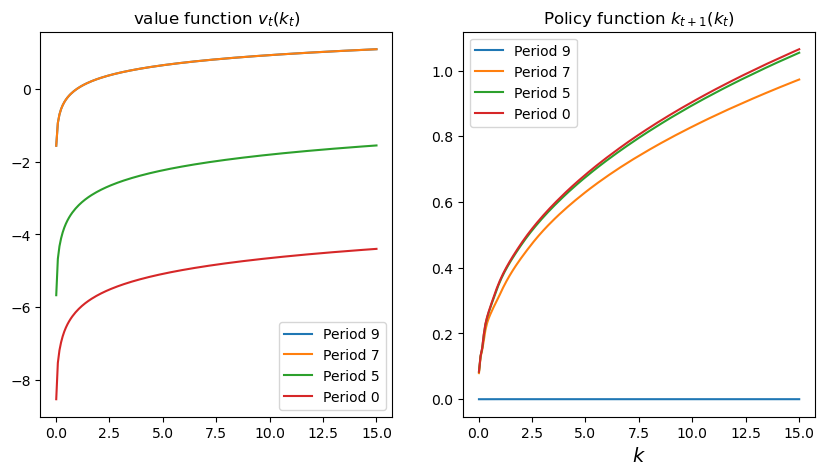

In [189]:
# apply the Backward Induction
model = Robinson_model()
vfunc,poli_func = Backward_indction(model)

# Draw the graph
plt.figure(figsize=(10, 5))
grid = model.grid
# Value Function
plt.subplot(1, 2, 1)
plt.plot(grid, vfunc[9,:], label='Period 9')
plt.plot(grid, vfunc[9,:], label='Period 7')
plt.plot(grid, vfunc[5,:], label='Period 5')
plt.plot(grid, vfunc[0,:], label='Period 0')
plt.title(r'value function $v_t(k_t)$')
plt.legend()

# Policy Function
plt.subplot(1, 2, 2)
plt.plot(grid, poli_func[9,:], label='Period 9')
plt.plot(grid, poli_func[7,:], label='Period 7')
plt.plot(grid, poli_func[5,:], label='Period 5')
plt.plot(grid, poli_func[0,:], label='Period 0')
plt.title( r'Policy function $k_{t+1}(k_t)$')
plt.legend()

plt.xlabel(r'$k$', fontsize=14)
plt.show()

## **Simulation**

Using the obtained policy functions, given any initial value $k_0$, we can compute the optimal consumption and savings paths.


In [191]:
def simulation(model, poli_func, k0):
    T = model.T  # Total number of periods
    grid = model.grid  # Capital grid
    f = model.f  # Production function

    # Initialize paths for capital (savings path) and consumption
    k_path = np.zeros(T+1)  # Capital path (savings path)
    c_path = np.zeros(T)    # Consumption path

    # Set the initial capital k_0
    k_path[0] = k0

    # Loop through each period, using interpolation on the policy function
    for t in range(T):
        # Get the current capital k_t
        k_t = k_path[t]

        # Interpolate the policy function for the current period t
        policy_interp = interp1d(grid, poli_func[t, :], kind='cubic', fill_value="extrapolate")

        # Use the interpolated function to find the optimal k_{t+1}
        k_path[t+1] = policy_interp(k_t)

        # Compute the consumption for the current period: c_t = f(k_t) - k_{t+1}
        c_path[t] = f(k_t) - k_path[t+1]
    
    return k_path, c_path

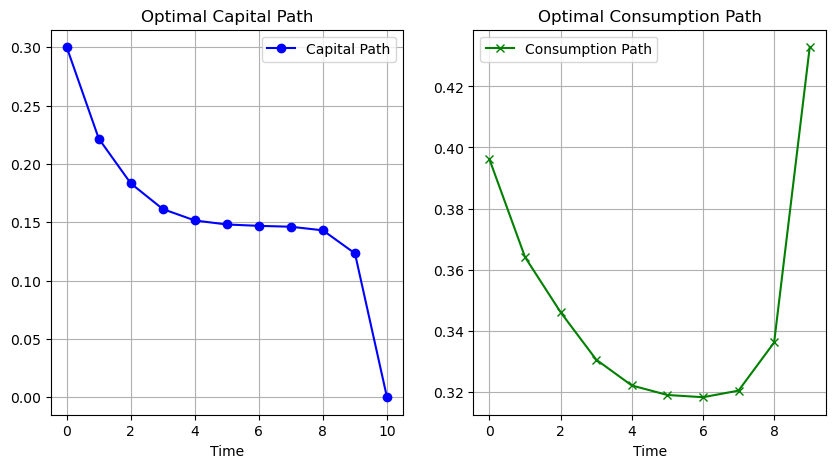

In [198]:
# Apply the simulation
k_path, c_path = simulation(model, poli_func, k0=0.3)

T = model.T
time = np.arange(T+1)
time_c = np.arange(T)

# Draw the graph
plt.figure(figsize=(10, 5))

# Plot capital path
plt.subplot(1, 2, 1)  # Create a subplot for the capital path
plt.plot(time, k_path, label="Capital Path", color='b', marker='o')
plt.title("Optimal Capital Path")
plt.xlabel("Time")
plt.grid(True)
plt.legend()

# Plot consumption path
plt.subplot(1, 2, 2)  # Create a subplot for the consumption path
plt.plot(time_c, c_path, label="Consumption Path", color='g', marker='x')
plt.title("Optimal Consumption Path")
plt.xlabel("Time")
plt.grid(True)
plt.legend()

plt.show()